In [44]:
import os
os.chdir('/Users/jjaniak/Documents/studia/projekt/gradient')

import geopandas as gpd
import pandas as pd
import json

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import shap
import numpy as np

from shapely.wkt import loads

from esda.moran import Moran_Local
import libpysal

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from src.embedders.osm_data_embedder import OSMDataEmbedder
from srai.regionalizers import geocode_to_region_gdf
from srai.embedders import CountEmbedder
from srai.regionalizers import H3Regionalizer
from srai.loaders.osm_loaders.filters import OsmTagsFilter

from IPython.display import display

pd.set_option("display.max_columns", None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

json_folder_path = "notebooks/accident_analysis/out/data_analysis_results/"

In [45]:
city_name = "Pozna\u0144"
nominatim_city_name = "Pozna\u0144, Poland"
year = 2022

In [46]:
# Parameters
city_name = "Szczecin"
nominatim_city_name = "Szczecin, Poland"
year = 2022


## Functions

In [48]:
query: OsmTagsFilter = {"highway": True, "railway": True, "route": True, "amenity": True}

def rename_columns_for_saving(hex_and_features_gdf):
    # Define a mapping for renaming columns
    column_mapping = {
        "highway": "H_",
        "railway": "R_",
        "amenity": "A_",
        "route": "RO_",
    }

    # Rename columns based on the defined mapping
    for prefix, replacement in column_mapping.items():
        columns_to_rename = [col for col in hex_and_features_gdf.columns if col.startswith(prefix + "_")]
        new_column_names = [replacement + col[len(prefix) + 1:] for col in columns_to_rename]
        hex_and_features_gdf.rename(columns=dict(zip(columns_to_rename, new_column_names)), inplace=True)

    return hex_and_features_gdf

def create_hex_gds(h3_resolution, city_name=city_name):
    data_embedder = OSMDataEmbedder(
        area=geocode_to_region_gdf(nominatim_city_name),
        embedder=CountEmbedder(),
        regionalizer=H3Regionalizer(resolution=h3_resolution),
        query=query,
    )
    filename = f"data/baseline-datasets/in/{city_name}-hex-res-{h3_resolution}-and-features_with_amenity-gdf_fixed_names.shp"
    if not os.path.exists(filename):
        hex_and_features_gdf = data_embedder.make_embeddings()  # type: ignore
        hex_and_features_gdf_fixed_names = rename_columns_for_saving(hex_and_features_gdf)
        hex_and_features_gdf_fixed_names.to_file(
            filename,
            index=True,
        )
    else:
        hex_and_features_gdf = gpd.read_file(filename)
        hex_and_features_gdf.set_index("region_id", inplace=True)

    return hex_and_features_gdf


def get_accidents_gdf(h3_resolution, city_name=city_name, year=year):
    filename = f"data/accidents_in_hex/{city_name}_accidents_{year}_res{h3_resolution}.csv"
    if not os.path.exists(filename):
        raise FileNotFoundError(f"The file {filename} does not exist.")
    else:
        accidents_df = pd.read_csv(filename)
        accidents_df['geometry'] = accidents_df['geometry'].apply(loads)
        accidents_gdf = gpd.GeoDataFrame(accidents_df, geometry='geometry', crs="EPSG:4326")
        return accidents_gdf
    
def merge_gdf(resolution):
    filename = f"data/accidents_in_hex/{city_name}_accidents_and_features_{year}_res{resolution}.shp"
    if not os.path.exists(filename):
        hex_and_features_gdf = create_hex_gds(h3_resolution=resolution, city_name=city_name)
        accidents_gdf = get_accidents_gdf(h3_resolution=resolution, city_name=city_name, year=year)
        merged_gdf = gpd.sjoin(left_df=accidents_gdf, right_df=hex_and_features_gdf, how='inner', op='intersects')
        merged_gdf = merged_gdf.drop(columns='index_right')
        merged_gdf['num_accidents'] = merged_gdf['count'].astype(int)
        merged_gdf.drop(columns=['count'], inplace=True)
        merged_gdf['binary_accidents'] = 0  # Initialize with 0
        merged_gdf.loc[merged_gdf["num_accidents"] > 0, "binary_accidents"] = 1.0
        merged_gdf.to_file(
            filename,
            index=True,
        )
    else:
        merged_gdf = gpd.read_file(filename)
        merged_gdf.set_index("region_id", inplace=True)
    
    merged_gdf.rename(columns={'num_accide': 'num_accidents', 'binary_acc': 'binary_accidents'}, inplace=True)
    return merged_gdf

In [49]:
def local_moran(df, column):
    w = libpysal.weights.Queen.from_dataframe(df)
    y = df[column].values
    moran_loc = Moran_Local(y, w)
    return moran_loc.Is, moran_loc.p_sim, moran_loc.q

In [50]:
from enum import Enum


class FeatureGoups(Enum):
    HIGHWAY = "H"
    RAILWAY = "R"
    AMENITY = "A"
    ROUTE  = "RO"
    

def analyze_features(merged_gdf:pd.DataFrame, feature_group: FeatureGoups):
    
    # Filter columns starting with feature group name
    feature_group_columns = merged_gdf.columns[merged_gdf.columns.str.startswith(feature_group.value)]

    # Sum values
    sum_feature_values = merged_gdf[feature_group_columns].sum()
    
    if sum_feature_values.size == 1:
        print(f"Found only one feature for feature group {feature_group.name}")
        display(sum_feature_values)
        return []
        
    else:
        plt.figure(figsize=(10, 6))
        sns.histplot(sum_feature_values, bins=50, kde=True, color='skyblue', edgecolor='black')
        plt.title(f'Histogram of {feature_group.name} Features')
        plt.xlabel('Sum')
        plt.ylabel('Frequency')
        plt.show()

        quartiles = sum_feature_values.quantile([0.25, 0.5, 0.75])

        iqr = quartiles[0.75] - quartiles[0.25]
        lower_bound = quartiles[0.25] - 1.5 * iqr
        upper_bound = quartiles[0.75] + 1.5 * iqr

        most_common_features = list(sum_feature_values[(sum_feature_values > upper_bound)].index)
        least_common_features = list(sum_feature_values[(sum_feature_values < lower_bound)].index)
        display(sum_feature_values.describe())
        print(f"\nMost common features for {feature_group.name}: \n {most_common_features}")
        if least_common_features:
            print(f"\nLeast common features for {feature_group.name}: \n {least_common_features}")
        
        return most_common_features
    
    
def analyze_imbalance(merged_gdf, feature_group):
    feature_group_columns = list(merged_gdf.columns[merged_gdf.columns.str.startswith(feature_group.value)]) + ['binary_accidents']
    grouped_data = merged_gdf[feature_group_columns].groupby('binary_accidents').sum()
    percentage_data = grouped_data.div(grouped_data.sum(axis=0))
        
    imbalance_ratio = abs(grouped_data.diff(axis=0) / grouped_data.sum(axis=0)).round(2)
    imbalance_ratio = imbalance_ratio.loc[1]
    
    print(f"\nMetrics of Imbalance in {feature_group.name}")
    if imbalance_ratio.size > 1:
        display(imbalance_ratio.T.describe())
    else:
        display(imbalance_ratio)
    
    high_imbalance_features = imbalance_ratio[imbalance_ratio >= 0.5]
    if high_imbalance_features.size > 0:
        print(f"\nThere are {len(high_imbalance_features)} high imbalance features in {feature_group.name}")
        for feature in high_imbalance_features.index:
            print(feature)
        display(percentage_data[high_imbalance_features.index])

        return high_imbalance_features.index
    else:
        return []

In [51]:
def correlation_analysis(merged_gdf, resolution):
    
    all_features = merged_gdf.drop(columns=['geometry', 'region_id', 'num_accidents', 'binary_accidents']).columns.to_list()
    
    correlation_matrix = merged_gdf[all_features + ['binary_accidents']].corr()
    correlation_values = correlation_matrix['binary_accidents']

    correlation_metrics = correlation_values.drop('binary_accidents').describe()

    # Filter features based on IQR 
    high_corr_features = correlation_values[(correlation_values >= 0.2) | (correlation_values <= -0.2)].index.to_list()
    low_corr_features = correlation_values[(correlation_values < 0.2) & (correlation_values > -0.2)].index.to_list()

    high_corr_features.remove('binary_accidents')
    correlation_matrix_best_features = merged_gdf[high_corr_features + ['binary_accidents']].corr()

    if high_corr_features != []:
        plt.figure(figsize=(14, 12))
        sns.heatmap(correlation_matrix_best_features, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 6})
        plt.title(f'Correlation Heatmap (best features) for resolution = {resolution}')
        plt.show()

    return high_corr_features, low_corr_features, correlation_metrics

In [52]:
def shap_analysis(h3_resolution, merged_gdf, selected_features, city_name=city_name, save_force_plot=False):
    print(f"Analysis for Resolution = {h3_resolution}")
    
    y = merged_gdf['binary_accidents']
    X = merged_gdf[selected_features]

    feature_names = X.columns.tolist()
    
    X_train, X_test, y_train, _ = train_test_split(X, y, test_size=0.3, random_state=42)
    
    scaler = preprocessing.StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_names)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=feature_names)
    
    linear_lr = LogisticRegression(max_iter=1000)
    linear_lr.fit(X_train_scaled, y_train)

    #Przygotowanie przybliżonej próbki tła za pomocą metody k-means.
    background_summary = shap.kmeans(X_train, 10)

    explainer = shap.KernelExplainer(linear_lr.predict_proba, background_summary)

    #Obliczenie SHAP wartości dla danych testowych (X_test), co pozwala na zrozumienie, jak każda zmienna przyczynia się do przewidywanej wartości.
    shap_values = explainer.shap_values(X_test_scaled)

    shap.summary_plot(shap_values, X_test_scaled)

    if save_force_plot:
        shap.initjs()
        p = shap.force_plot(explainer.expected_value[0], shap_values[0], X_test_scaled)
        shap.save_html(json_folder_path + f'{city_name}_res_{h3_resolution}_force_plot_best_features.html', p)

## Analysis

In [53]:
# Set resolutions
resolutions = [8, 9, 10]

# Initialize dataframe and dictionaries to store results
distribution_results = pd.DataFrame(columns=['Resolution', 'Num_Hexes', 'Accidents_Mean', 'Accidents_Std','Binary_Accidents_Mean', 'Binary_Accidents_Std'])

local_moran_results = {} 
highest_imbalance_features_dict = {}


# Loop through resolutions
for resolution in resolutions:
    
    print(f"Analysis for Resolution = {resolution}")
    
    # Create hex dataframes
    merged_gdf = merge_gdf(resolution)
    
    # Accidents Distribution
    new_row = {
        'Resolution': resolution,
        'Num_Hexes': len(merged_gdf),
        'Accidents_Mean': merged_gdf['num_accidents'].mean(),
        'Accidents_Std': merged_gdf['num_accidents'].std(),
        'Binary_Accidents_Mean': merged_gdf['binary_accidents'].mean(),
        'Binary_Accidents_Std': merged_gdf['binary_accidents'].std()
    }
    result_df = pd.DataFrame([new_row], columns=distribution_results.columns)
    distribution_results = pd.concat([distribution_results, result_df], ignore_index=True)

    # Calculate Local Moran's I
    moran_i, p_sim, q = local_moran(merged_gdf, column='num_accidents')
    local_moran_results[resolution] = {'moran_i': moran_i, 'p_sim': p_sim, 'q': q}

Analysis for Resolution = 8
Analysis for Resolution = 9
Analysis for Resolution = 10


### Rozkład wypadków

In [10]:
print("Distribution of Accidents in Hexes:")
display(distribution_results) 

Distribution of Accidents in Hexes:


,Resolution,Num_Hexes,Accidents_Mean,Accidents_Std,Binary_Accidents_Mean,Binary_Accidents_Std
0,8,3644,0.655598,2.250005,0.199232,0.399477
1,9,23860,0.100084,0.575824,0.063537,0.243932
2,10,162081,0.014752,0.188183,0.011741,0.107718


#### Wnioski:

- Wzrastająca rozdzielczość (malejący rozmiar heksagonów) skutkuje spadkiem średniej liczby wypadków na heksagon.
- Odchylenie standardowe liczby wypadków na heksagon jest najwyższe dla rozdzielczości 8, co oznacza większą zmienność w liczbie wypadków między heksagonami w tej rozdzielczości.
- Wartości binarne (czy w danym heksagonie wystąpił przynajmniej jeden wypadek) mają niższe średnie i odchylenia standardowe, co sugeruje, że większość heksagonów nie ma w ogóle wypadków.
- Spadek średniej liczby wypadków na heksagon wraz ze wzrostem rozdzielczości może wynikać z bardziej szczegółowego podziału obszaru, co skutkuje mniejszymi obszarami z mniejszą liczbą wypadków. 
- Większe odchylenie standardowe dla rozdzielczości 8 wskazuje na bardziej zróżnicowane rozkłady liczby wypadków między heksagonami.

### Correlation

Analysis for Resolution = 8


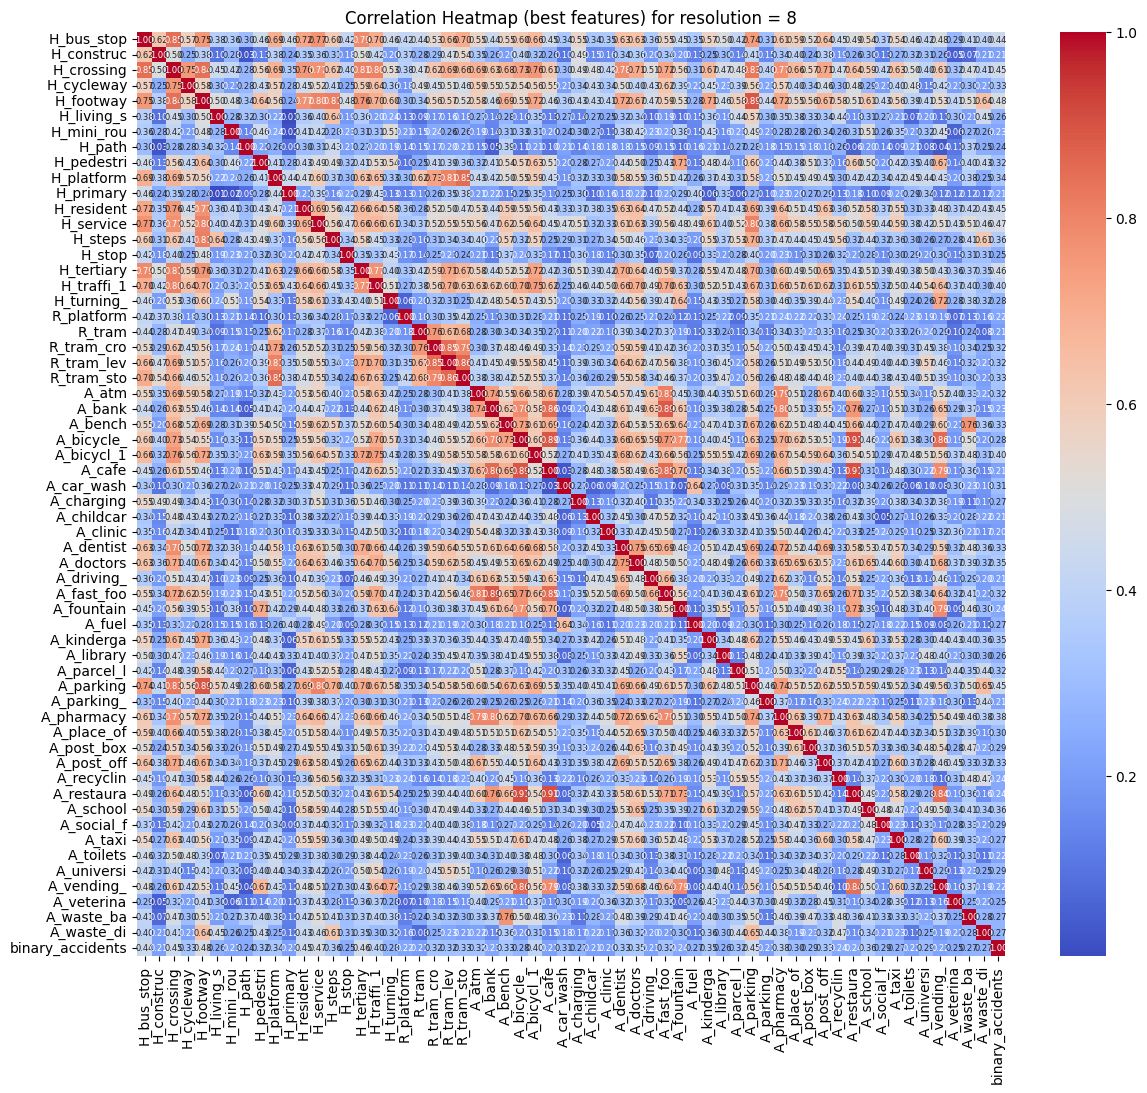

Analysis for Resolution = 9


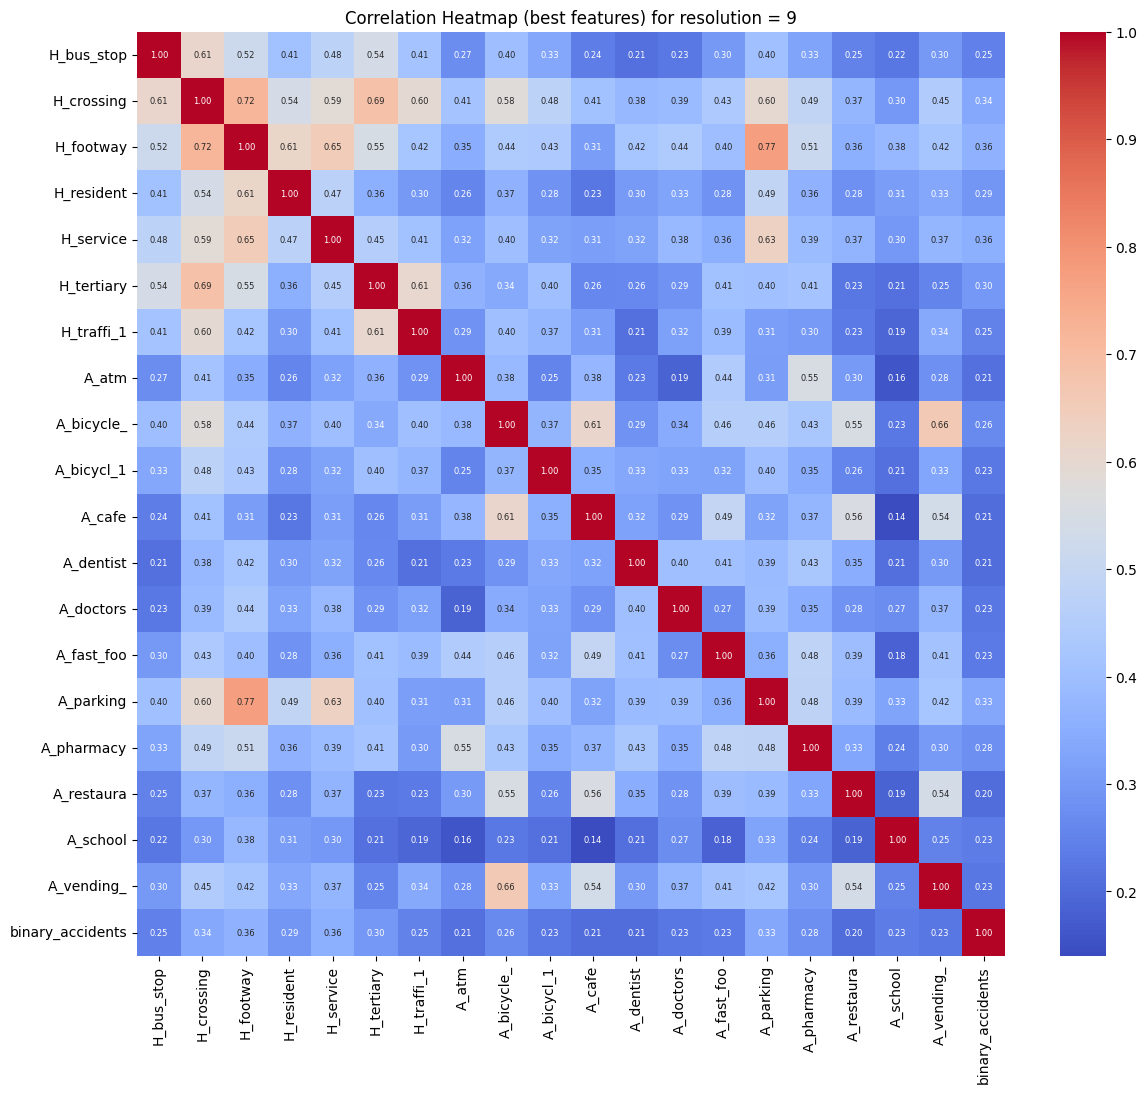

Analysis for Resolution = 10


In [11]:
df_correlation_metrics = pd.DataFrame()

all_high_corr_features = {}
all_low_corr_features = {}

# Loop through resolutions
for resolution in resolutions:
    print(f"Analysis for Resolution = {resolution}")
    merged_gdf = merge_gdf(resolution)
    merged_gdf.reset_index(inplace=True)
    highest_corr_features, low_corr_features, correlation_metrics = correlation_analysis(merged_gdf, resolution)
    all_low_corr_features[resolution] = low_corr_features
    all_high_corr_features[resolution] = highest_corr_features
    df_correlation_metrics = pd.concat([df_correlation_metrics, correlation_metrics], axis=1)


file_path = json_folder_path + f'all_high_corr_features_{city_name}.json'
with open(file_path, 'w') as json_file:
    json.dump(all_high_corr_features, json_file)
    
file_path = json_folder_path + f'all_low_corr_features_{city_name}.json'
with open(file_path, 'w') as json_file:
    json.dump(all_low_corr_features, json_file)

In [12]:
df_correlation_metrics.columns = [f'resolution={resolution}' for resolution in resolutions]
print("Correlation Metrics of Binary Accidents with All Features:")
display(df_correlation_metrics)

Correlation Metrics of Binary Accidents with All Features:


,resolution=8,resolution=9,resolution=10
count,186.000000,186.000000,186.000000
mean,0.153004,0.080547,0.028377
std,0.120831,0.084007,0.036509
min,-0.026572,-0.025060,-0.020561
25%,0.067882,0.015485,0.001927
50%,0.118463,0.052240,0.016715
75%,0.230531,0.127042,0.041742
max,0.482771,0.362883,0.186623


In [13]:
file_path = json_folder_path + f'all_high_corr_features_{city_name}.json'
with open(file_path, 'r') as json_file:
    all_high_corr_features = json.load(json_file)
    
print("Best Features Based on Correlation:\n")
for resolution, best_features in all_high_corr_features.items():
    print(f"\nResolution {resolution}:")
    for feature in best_features:
        print(f"{feature}")

Best Features Based on Correlation:


Resolution 8:
H_bus_stop
H_construc
H_crossing
H_cycleway
H_footway
H_living_s
H_mini_rou
H_path
H_pedestri
H_platform
H_primary
H_resident
H_service
H_steps
H_stop
H_tertiary
H_traffi_1
H_turning_
R_platform
R_tram
R_tram_cro
R_tram_lev
R_tram_sto
A_atm
A_bank
A_bench
A_bicycle_
A_bicycl_1
A_cafe
A_car_wash
A_charging
A_childcar
A_clinic
A_dentist
A_doctors
A_driving_
A_fast_foo
A_fountain
A_fuel
A_kinderga
A_library
A_parcel_l
A_parking
A_parking_
A_pharmacy
A_place_of
A_post_box
A_post_off
A_recyclin
A_restaura
A_school
A_social_f
A_taxi
A_toilets
A_universi
A_vending_
A_veterina
A_waste_ba
A_waste_di

Resolution 9:
H_bus_stop
H_crossing
H_footway
H_resident
H_service
H_tertiary
H_traffi_1
A_atm
A_bicycle_
A_bicycl_1
A_cafe
A_dentist
A_doctors
A_fast_foo
A_parking
A_pharmacy
A_restaura
A_school
A_vending_

Resolution 10:


In [14]:
common_features = set(all_high_corr_features['8']) & set(all_high_corr_features['9']) & set(all_high_corr_features['10'])
if common_features != []:
    print("Common Features With High Correlation Across All Resolutions:")
    for feature in common_features:
        print(feature)
    
common_features = set(all_high_corr_features['8']) & set(all_high_corr_features['9'])
if common_features != []:
    print("Common Features With High Correlation Across Resolutions 8 and 9:")
    for feature in common_features:
        print(feature)

Common Features With High Correlation Across All Resolutions:
Common Features With High Correlation Across Resolutions 8 and 9:
A_vending_
A_school
A_doctors
H_service
A_bicycle_
A_bicycl_1
A_cafe
H_tertiary
H_bus_stop
A_restaura
A_dentist
H_resident
H_traffi_1
A_pharmacy
H_crossing
A_atm
A_parking
H_footway
A_fast_foo


In [15]:
file_path = json_folder_path + f'all_low_corr_features_{city_name}.json'
with open(file_path, 'r') as json_file:
    all_low_corr_features = json.load(json_file)


common_features = set(all_low_corr_features['8']) & set(all_low_corr_features['9']) & set(all_low_corr_features['10'])
if common_features != []:
    print("Common Features With Low Correlation Across All Resolutions:")
    for feature in common_features:
        print(feature)

Common Features With Low Correlation Across All Resolutions:
A_baby_hat
A_drinking
A_marketpl
R_disused
H_street_l
R_abandone
A_dojo
H_second_1
A_hospital
A_bar
A_car_rent
R_site
R_stop
R_proposed
A_ice_crea
R_buffer_s
A_boat_ren
H_track
A_shower
A_cooking_
R_railway_
R_roundhou
H_traffic_
H_trunk
A_music_sc
A_public_1
A_pub
H_raceway
A_funeral_
A_shelter
A_police
A_food_sha
A_arts_cen
A_bbq
A_device_c
A_hunting_
A_water_po
A_vehicle_
R_light_ra
A_jobcentr
A_food_cou
A_post_dep
R_construc
A_warehous
A_internet
H_motorw_2
A_parkin_1
A_prison
A_dormitor
R_razed
A_prep_sch
R_junction
R_turntabl
A_nursing_
H_elevator
A_accounti
A_clock
A_loading_
A_trolley_
A_bicycl_2
A_events_v
A_ferry_te
A_grit_bin
A_studio
H_unclassi
A_townhall
R_station
A_public_2
A_traffic_
H_proposed
A_luggage_
H_secondar
A_grave_ya
A_compress
A_courthou
A_social_c
A_lounger
A_conferen
RO_mtb
A_language
R_derail
A_motorcyc
A_receptio
A_vacuum_c
H_mileston
R_rail
R_rail_bra
H_corridor
A_cinema
A_construc
A_theatre
A_s

### Istotne cechy

In [16]:
file_path = json_folder_path + f'all_high_corr_features_{city_name}.json'
with open(file_path, 'r') as json_file:
    all_high_corr_features = json.load(json_file)
    
# Loop through resolutions
for resolution in resolutions:
    print(f"Analysis for Resolution = {resolution}")
    merged_gdf = merge_gdf(resolution)
    merged_gdf.reset_index(inplace=True)
    highest_corr_features = all_high_corr_features[str(resolution)]
    
    # Summary statistics of numerical columns
    summary_statistics = merged_gdf.describe()

    all_high_imbalance_features = []
    
    feature_groups = [FeatureGoups.AMENITY, FeatureGoups.HIGHWAY, FeatureGoups.RAILWAY, FeatureGoups.ROUTE]
    for feature_group in feature_groups:
        feature_group_columns = list(merged_gdf.columns[merged_gdf.columns.str.startswith(feature_group.value)])
        mean_row = summary_statistics[feature_group_columns].loc['mean']
        sorted_columns = mean_row.sort_values().index
        summary_statistics_sorted = summary_statistics[sorted_columns]
        print(f"\nSummary Statistics of Numerical Columns (Sorted by Mean) for {feature_group.name}:")
        display(summary_statistics_sorted)
        all_high_imbalance_features.extend(analyze_imbalance(merged_gdf, feature_group))
        highest_imbalance_features_dict[resolution] = all_high_imbalance_features
        

    filtered_columns = summary_statistics.columns[summary_statistics.loc['mean'] > 1]
    common_features_mean_more_than_1 = set(filtered_columns) & set(highest_corr_features)
    if common_features_mean_more_than_1:
        print(f"\nCommon features with mean in hex more than 1 and high correlation:")
        print(common_features_mean_more_than_1)
    else:
        print(f"\nThere is no common features with mean in hex more than 1 and high correlation.")
        
    filtered_columns = summary_statistics.columns[summary_statistics.loc['mean'] < 0.01]
    common_features_mean_less_than_001 = set(filtered_columns) & set(highest_corr_features)
    if common_features_mean_less_than_001:
        print(f"\nCommon features with mean in hex less than 0.01 and high correlation:")
        print(common_features_mean_less_than_001)
    else:
        print(f"\nThere is no common features with mean in hex less than 0.01 and high correlation.")
        
    common_features_highest_corr_and_imbalance = set(all_high_imbalance_features) & set(highest_corr_features)
    if common_features_highest_corr_and_imbalance:
        print(f"\nCommon features with high imbalance and high correlation:")
        print(common_features_highest_corr_and_imbalance)
    else:
        print(f"\nThere is no common features with high imbalance and high correlation.")
    

file_path = json_folder_path + f'highest_imbalance_features_dict_{city_name}.json'
with open(file_path, 'w') as json_file:
    json.dump(highest_imbalance_features_dict, json_file)

Analysis for Resolution = 8

Summary Statistics of Numerical Columns (Sorted by Mean) for AMENITY:


,A_receptio,A_accounti,A_construc,A_cooking_,A_device_c,A_dormitor,A_funeral_,A_internet,A_luggage_,A_monaster,A_money_tr,A_prison,A_public_1,A_townhall,A_trade_sc,A_traffic_,A_warehous,A_water_po,A_conferen,A_casino,A_jobcentr,A_baby_hat,A_animal_s,A_animal_b,A_post_dep,A_prep_sch,A_grave_ya,A_events_v,A_bus_stat,A_public_2,A_student_,A_food_sha,A_dressing,A_loading_,A_hunting_,A_boat_ren,A_food_cou,A_nursing_,A_dive_cen,A_biergart,A_studio,A_training,A_motorcyc,A_public_b,A_shower,A_ferry_te,A_trolley_,A_social_c,A_grit_bin,A_bicycl_2,A_arts_cen,A_cinema,A_music_sc,A_car_rent,A_courthou,A_dojo,A_lounger,A_weighbri,A_language,A_water_ta,A_police,A_college,A_bbq,A_fire_sta,A_theatre,A_clock,A_vacuum_c,A_driving_,A_hospital,A_childcar,A_vehicle_,A_drinking,A_compress,A_communit,A_bar,A_marketpl,A_nightclu,A_ice_crea,A_clinic,A_library,A_veterina,A_fountain,A_bureau_d,A_taxi,A_charging,A_social_f,A_pub,A_post_box,A_toilets,A_post_off,A_fuel,A_car_wash,A_place_of,A_universi,A_bank,A_parcel_l,A_cafe,A_bicycl_1,A_kinderga,A_dentist,A_atm,A_pharmacy,A_doctors,A_school,A_fast_foo,A_vending_,A_restaura,A_waste_di,A_parking_,A_shelter,A_recyclin,A_parkin_1,A_bicycle_,A_waste_ba,A_bench,A_parking
count,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.00000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000
mean,0.000823,0.001921,0.001921,0.001921,0.001921,0.001921,0.001921,0.001921,0.001921,0.001921,0.001921,0.001921,0.001921,0.001921,0.001921,0.001921,0.001921,0.001921,0.001921,0.001921,0.001921,0.001921,0.003293,0.003842,0.003842,0.003842,0.003842,0.003842,0.003842,0.003842,0.003842,0.003842,0.003842,0.003842,0.005214,0.005763,0.005763,0.005763,0.005763,0.005763,0.005763,0.005763,0.005763,0.006037,0.007684,0.007684,0.007684,0.007684,0.009605,0.011251,0.011526,0.011526,0.011526,0.013447,0.015368,0.015368,0.016465,0.017014,0.017289,0.017289,0.017289,0.017289,0.017289,0.01921,0.019210,0.019210,0.021131,0.026894,0.026894,0.026894,0.028266,0.030735,0.032656,0.038419,0.040340,0.044182,0.044182,0.049945,0.057903,0.059550,0.062843,0.068880,0.069155,0.084523,0.087816,0.088364,0.088364,0.107025,0.119923,0.124863,0.137761,0.152580,0.166301,0.167124,0.178650,0.184962,0.191273,0.199780,0.211855,0.224479,0.245884,0.283205,0.285950,0.358397,0.440176,0.467892,0.514270,0.578760,0.630900,0.802415,0.840285,0.878156,0.992316,1.478046,5.035950,8.817508
std,0.028685,0.043793,0.043793,0.043793,0.043793,0.043793,0.043793,0.043793,0.043793,0.043793,0.043793,0.043793,0.043793,0.043793,0.043793,0.043793,0.043793,0.043793,0.043793,0.043793,0.043793,0.043793,0.057299,0.061873,0.061873,0.061873,0.061873,0.061873,0.087585,0.087585,0.061873,0.061873,0.087585,0.087585,0.072030,0.075705,0.075705,0.097848,0.0


Metrics of Imbalance in AMENITY


count    116.000000
mean       0.491897
std        0.292705
min        0.040000
25%        0.240000
50%        0.455000
75%        0.710000
max        1.000000
Name: 1, dtype: float64


There are 54 high imbalance features in AMENITY
A_animal_s
A_baby_hat
A_bank
A_bar
A_bicycle_
A_bicycl_1
A_bureau_d
A_bus_stat
A_cafe
A_car_rent
A_casino
A_college
A_conferen
A_courthou
A_dentist
A_device_c
A_dive_cen
A_dojo
A_driving_
A_fast_foo
A_ferry_te
A_food_cou
A_food_sha
A_fountain
A_funeral_
A_hunting_
A_ice_crea
A_internet
A_jobcentr
A_loading_
A_luggage_
A_marketpl
A_money_tr
A_motorcyc
A_music_sc
A_nightclu
A_nursing_
A_police
A_prison
A_pub
A_public_b
A_public_2
A_receptio
A_restaura
A_social_c
A_studio
A_townhall
A_trade_sc
A_trolley_
A_universi
A_vending_
A_water_po
A_water_ta
A_weighbri


,A_animal_s,A_baby_hat,A_bank,A_bar,A_bicycle_,A_bicycl_1,A_bureau_d,A_bus_stat,A_cafe,A_car_rent,A_casino,A_college,A_conferen,A_courthou,A_dentist,A_device_c,A_dive_cen,A_dojo,A_driving_,A_fast_foo,A_ferry_te,A_food_cou,A_food_sha,A_fountain,A_funeral_,A_hunting_,A_ice_crea,A_internet,A_jobcentr,A_loading_,A_luggage_,A_marketpl,A_money_tr,A_motorcyc,A_music_sc,A_nightclu,A_nursing_,A_police,A_prison,A_pub,A_public_b,A_public_2,A_receptio,A_restaura,A_social_c,A_studio,A_townhall,A_trade_sc,A_trolley_,A_universi,A_vending_,A_water_po,A_water_ta,A_weighbri
binary_accidents,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.75,0.0,0.132104,0.163265,0.230365,0.226648,0.083333,0.142857,0.153515,0.122449,0.142857,0.079365,0.0,0.142857,0.246944,0.142857,0.0,0.232143,0.153061,0.19389,0.785714,0.142857,0.071429,0.191235,0.0,0.947368,0.230769,0.0,0.0,0.142857,0.142857,0.192547,0.0,0.095238,0.119048,0.099379,0.190476,0.15873,0.142857,0.186335,0.818182,0.142857,1.0,0.213447,0.142857,0.047619,0.0,0.0,0.0,0.131363,0.107331,1.0,0.015873,0.758065
1,0.25,1.0,0.867896,0.836735,0.769635,0.773352,0.916667,0.857143,0.846485,0.877551,0.857143,0.920635,1.0,0.857143,0.753056,0.857143,1.0,0.767857,0.846939,0.80611,0.214286,0.857143,0.928571,0.808765,1.0,0.052632,0.769231,1.0,1.0,0.857143,0.857143,0.807453,1.0,0.904762,0.880952,0.900621,0.809524,0.84127,0.857143,0.813665,0.181818,0.857143,0.0,0.786553,0.857143,0.952381,1.0,1.0,1.0,0.868637,0.892669,0.0,0.984127,0.241935



Summary Statistics of Numerical Columns (Sorted by Mean) for HIGHWAY:


,H_corridor,H_speed_ca,H_raceway,H_passing_,H_motorw_1,H_traffic_,H_primary_,H_trunk,H_second_1,H_mini_rou,H_mileston,H_elevator,H_stop,H_give_way,H_motorw_2,H_motorway,H_platform,H_secondar,H_turning_,H_pedestri,H_traffi_1,H_primary,H_unclassi,H_proposed,H_bus_stop,H_construc,H_living_s,H_cycleway,H_steps,H_tertiary,H_track,H_path,H_street_l,H_resident,H_crossing,H_service,H_footway
count,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000
mean,0.005763,0.007684,0.017289,0.020307,0.020856,0.021131,0.030735,0.040615,0.042261,0.051866,0.079583,0.103732,0.186334,0.246981,0.256037,0.348244,0.512898,0.628430,1.043359,1.045554,1.070801,1.254116,1.343853,1.677003,2.271405,2.611965,3.299396,3.310922,4.748902,4.754940,6.102086,6.419868,6.568332,7.686883,10.817783,26.884193,47.864984
std,0.075705,0.087332,0.243449,0.197776,0.167669,0.143839,0.289138,0.672994,0.963440,0.254089,0.291202,0.877133,0.702624,1.266529,1.970418,1.832925,1.728036,3.322987,3.071262,4.252478,3.675700,4.817011,4.087908,4.750221,4.228726,13.687358,10.684664,11.240816,13.340936,11.503215,9.541737,12.149241,22.815290,14.379925,26.490522,46.127987,110.753975
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,5.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,0.000000,1.000000,1.000000,2.000000,3.000000,9.000000,8.000000,0.000000,10.000000,8.000000,35.250000,32.000000
max,1.000000,1.000000,5.000000,3.000000,2.000000,1.000000,4.000000,16.000000,22.000000,3.000000,2.000000,16.000000,7.000000,16.000000,32.000000,17.000000,14.000000,35.000000,42.000000,52.000000,31.000000,44.000000,40.000000,53.000000,50.000000,215.000000,109.000000,115.000000,116.000000,111.000000,110.000000,98.000000,210.000000,87.000000,226.000000,300.000000,819.000000



Metrics of Imbalance in HIGHWAY


count    37.000000
mean      0.273514
std       0.190631
min       0.020000
25%       0.140000
50%       0.280000
75%       0.340000
max       0.780000
Name: 1, dtype: float64


There are 6 high imbalance features in HIGHWAY
H_motorway
H_motorw_1
H_passing_
H_track
H_traffi_1
H_trunk


,H_motorway,H_motorw_1,H_passing_,H_track,H_traffi_1,H_trunk
binary_accidents,,,,,,
0,0.803783,0.789474,0.891892,0.751799,0.250897,0.817568
1,0.196217,0.210526,0.108108,0.248201,0.749103,0.182432



Summary Statistics of Numerical Columns (Sorted by Mean) for RAILWAY:


,R_rail_bra,R_traverse,R_containe,R_roundhou,R_owner_ch,R_site,R_junction,R_halt,R_station,R_turntabl,R_razed,RO_ferry,R_railway_,R_signal_b,R_proposed,RO_mtb,R_light_ra,R_stop,R_derail,R_platform,R_crossing,R_construc,R_disused,R_tram_sto,R_switch,R_abandone,R_buffer_s,R_level_cr,R_tram_cro,R_tram,R_tram_lev,R_rail
count,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000
mean,0.001921,0.001921,0.001921,0.001921,0.001921,0.003568,0.003842,0.007684,0.009605,0.019210,0.019210,0.023052,0.028814,0.037047,0.039517,0.044731,0.059550,0.062843,0.080681,0.121021,0.230241,0.262349,0.455269,0.489846,0.526345,0.588639,0.599890,0.711306,0.902854,1.237102,1.440724,3.463227
std,0.043793,0.043793,0.043793,0.043793,0.043793,0.059630,0.061873,0.087332,0.097546,0.315513,0.315513,0.246893,0.530687,0.198815,0.303837,0.468529,0.660662,0.421300,0.598809,0.542872,1.205922,1.406545,2.027515,1.768718,2.872364,2.652868,2.546124,3.380699,3.689857,6.809134,6.051345,10.851531
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,7.000000,4.000000,12.000000,2.000000,4.000000,8.000000,13.000000,6.000000,9.000000,6.000000,14.000000,14.000000,20.000000,18.000000,38.000000,28.000000,31.000000,37.000000,39.000000,124.000000,56.000000,96.000000



Metrics of Imbalance in RAILWAY


count    32.000000
mean      0.306562
std       0.227080
min       0.010000
25%       0.127500
50%       0.305000
75%       0.430000
max       1.000000
Name: 1, dtype: float64


There are 4 high imbalance features in RAILWAY
R_containe
R_junction
R_owner_ch
R_traverse


,R_containe,R_junction,R_owner_ch,R_traverse
binary_accidents,,,,
0,1.0,0.785714,0.857143,0.857143
1,0.0,0.214286,0.142857,0.142857



Summary Statistics of Numerical Columns (Sorted by Mean) for ROUTE:


,RO_ferry,RO_mtb
count,3644.000000,3644.000000
mean,0.023052,0.044731
std,0.246893,0.468529
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,4.000000,8.000000



Metrics of Imbalance in ROUTE


count    2.000000
mean     0.240000
std      0.311127
min      0.020000
25%      0.130000
50%      0.240000
75%      0.350000
max      0.460000
Name: 1, dtype: float64


Common features with mean in hex more than 1 and high correlation:
{'H_turning_', 'H_service', 'A_bench', 'H_tertiary', 'H_bus_stop', 'H_cycleway', 'H_resident', 'R_tram', 'H_traffi_1', 'H_living_s', 'R_tram_lev', 'H_pedestri', 'H_path', 'H_construc', 'A_waste_ba', 'H_crossing', 'A_parking', 'H_primary', 'H_footway', 'H_steps'}

There is no common features with mean in hex less than 0.01 and high correlation.

Common features with high imbalance and high correlation:
{'A_vending_', 'H_traffi_1', 'A_dentist', 'A_universi', 'A_fountain', 'A_restaura', 'A_bicycle_', 'A_fast_foo', 'A_bicycl_1', 'A_cafe', 'A_bank', 'A_driving_'}
Analysis for Resolution = 9

Summary Statistics of Numerical Columns (Sorted by Mean) for AMENITY:


,A_receptio,A_accounti,A_construc,A_cooking_,A_device_c,A_dormitor,A_funeral_,A_internet,A_luggage_,A_monaster,A_money_tr,A_public_1,A_townhall,A_trade_sc,A_warehous,A_water_po,A_conferen,A_casino,A_jobcentr,A_baby_hat,A_animal_b,A_food_sha,A_traffic_,A_post_dep,A_prep_sch,A_student_,A_events_v,A_prison,A_dressing,A_loading_,A_hunting_,A_grave_ya,A_nursing_,A_food_cou,A_dive_cen,A_motorcyc,A_public_2,A_training,A_biergart,A_bus_stat,A_studio,A_public_b,A_animal_s,A_trolley_,A_shower,A_social_c,A_boat_ren,A_ferry_te,A_grit_bin,A_cinema,A_bicycl_2,A_music_sc,A_car_rent,A_dojo,A_arts_cen,A_weighbri,A_courthou,A_water_ta,A_language,A_college,A_lounger,A_bbq,A_fire_sta,A_police,A_clock,A_theatre,A_vacuum_c,A_childcar,A_driving_,A_vehicle_,A_drinking,A_compress,A_communit,A_bar,A_nightclu,A_marketpl,A_ice_crea,A_library,A_hospital,A_veterina,A_bureau_d,A_clinic,A_fountain,A_pub,A_charging,A_taxi,A_social_f,A_post_box,A_toilets,A_post_off,A_fuel,A_car_wash,A_place_of,A_bank,A_parcel_l,A_cafe,A_bicycl_1,A_universi,A_dentist,A_atm,A_kinderga,A_pharmacy,A_doctors,A_fast_foo,A_vending_,A_school,A_restaura,A_waste_di,A_parking_,A_shelter,A_recyclin,A_parkin_1,A_bicycle_,A_waste_ba,A_bench,A_parking
count,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000
mean,0.000168,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000587,0.000587,0.000587,0.000587,0.000587,0.000587,0.000587,0.000587,0.000587,0.000587,0.000838,0.000880,0.000880,0.000880,0.000880,0.000880,0.000880,0.000880,0.000880,0.000880,0.000880,0.000964,0.001132,0.001174,0.001174,0.001174,0.001174,0.001174,0.001467,0.001760,0.001760,0.002054,0.002054,0.002347,0.002347,0.002598,0.002640,0.002640,0.002640,0.002640,0.002640,0.002640,0.002934,0.002934,0.002934,0.003227,0.003227,0.003814,0.004107,0.004275,0.004694,0.004946,0.005868,0.006161,0.006748,0.007628,0.007628,0.009095,0.009807,0.009891,0.010562,0.011609,0.011735,0.013202,0.013370,0.014082,0.015759,0.016429,0.018399,0.019070,0.021961,0.025775,0.027033,0.027284,0.028290,0.029338,0.030511,0.031978,0.034241,0.037552,0.040235,0.043252,0.046354,0.067728,0.071542,0.075063,0.078625,0.091031,0.096815,0.124225,0.130008,0.140696,0.152347,0.226739,0.771626,1.514753
std,0.012947,0.017126,0.017126,0.017126,0.017126,0.017126,0.017126,0.017126,0.017126,0.017126,0.017126,0.017126,0.017126,0.017126,0.017126,0.017126,0.017126,0.017126,0.017126,0.017126,0.024216,0.024216,0.024216,0.024216,0.024216,0.


Metrics of Imbalance in AMENITY


count    116.000000
mean       0.400603
std        0.272500
min        0.010000
25%        0.197500
50%        0.375000
75%        0.532500
max        1.000000
Name: 1, dtype: float64


There are 37 high imbalance features in AMENITY
A_accounti
A_animal_s
A_arts_cen
A_bicycl_2
A_boat_ren
A_construc
A_cooking_
A_device_c
A_dressing
A_drinking
A_events_v
A_ferry_te
A_grave_ya
A_grit_bin
A_hospital
A_hunting_
A_internet
A_loading_
A_lounger
A_monaster
A_motorcyc
A_post_dep
A_prison
A_public_b
A_receptio
A_recyclin
A_shelter
A_shower
A_toilets
A_traffic_
A_training
A_vacuum_c
A_vehicle_
A_warehous
A_waste_di
A_water_po
A_weighbri


,A_accounti,A_animal_s,A_arts_cen,A_bicycl_2,A_boat_ren,A_construc,A_cooking_,A_device_c,A_dressing,A_drinking,A_events_v,A_ferry_te,A_grave_ya,A_grit_bin,A_hospital,A_hunting_,A_internet,A_loading_,A_lounger,A_monaster,A_motorcyc,A_post_dep,A_prison,A_public_b,A_receptio,A_recyclin,A_shelter,A_shower,A_toilets,A_traffic_,A_training,A_vacuum_c,A_vehicle_,A_warehous,A_waste_di,A_water_po,A_weighbri
binary_accidents,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.857143,0.888889,0.803571,0.785714,0.75,1.0,0.857143,0.857143,1.0,0.75,0.785714,0.928571,0.809524,0.885714,0.811966,1.0,0.0,0.857143,0.904762,1.0,0.238095,1.0,0.214286,0.869565,1.0,0.758543,0.796221,0.928571,0.77221,0.928571,0.761905,0.753247,0.764706,0.857143,0.755985,1.0,0.951613
1,0.142857,0.111111,0.196429,0.214286,0.25,0.0,0.142857,0.142857,0.0,0.25,0.214286,0.071429,0.190476,0.114286,0.188034,0.0,1.0,0.142857,0.095238,0.0,0.761905,0.0,0.785714,0.130435,0.0,0.241457,0.203779,0.071429,0.22779,0.071429,0.238095,0.246753,0.235294,0.142857,0.244015,0.0,0.048387



Summary Statistics of Numerical Columns (Sorted by Mean) for HIGHWAY:


,H_corridor,H_speed_ca,H_passing_,H_traffic_,H_motorw_1,H_raceway,H_primary_,H_mini_rou,H_trunk,H_second_1,H_mileston,H_elevator,H_stop,H_give_way,H_motorw_2,H_motorway,H_platform,H_secondar,H_turning_,H_traffi_1,H_pedestri,H_primary,H_unclassi,H_proposed,H_bus_stop,H_construc,H_cycleway,H_living_s,H_steps,H_tertiary,H_street_l,H_path,H_track,H_resident,H_crossing,H_service,H_footway
count,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.00000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000
mean,0.000880,0.001174,0.003185,0.003227,0.003227,0.003814,0.006454,0.007921,0.008005,0.008801,0.012196,0.015842,0.028458,0.037720,0.046731,0.075608,0.088894,0.11492,0.159723,0.164040,0.197988,0.235163,0.261148,0.333529,0.347737,0.438600,0.593210,0.605826,0.743001,0.881433,1.005574,1.237427,1.332188,1.516136,1.656664,4.736756,8.179715
std,0.029655,0.034237,0.070254,0.056718,0.061674,0.117366,0.125704,0.091900,0.221206,0.303393,0.109763,0.294266,0.220846,0.296539,0.626506,0.668475,0.521810,1.10660,0.786328,0.938709,1.222693,1.405406,1.220001,1.470554,1.036365,3.935601,3.170469,2.603841,3.205156,3.038912,4.824296,3.066580,2.822071,3.343345,5.235905,9.632276,21.557403
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,0.000000,5.000000,3.000000
max,1.000000,1.000000,3.000000,1.000000,2.000000,6.000000,4.000000,2.000000,10.000000,12.000000,1.000000,14.000000,4.000000,5.000000,14.000000,14.000000,12.000000,30.00000,26.000000,13.000000,26.000000,19.000000,27.000000,30.000000,26.000000,87.000000,57.000000,35.000000,75.000000,41.000000,59.000000,35.000000,50.000000,35.000000,96.000000,129.000000,234.000000



Metrics of Imbalance in HIGHWAY


count    37.000000
mean      0.557838
std       0.204412
min       0.170000
25%       0.410000
50%       0.520000
75%       0.750000
max       0.920000
Name: 1, dtype: float64


There are 21 high imbalance features in HIGHWAY
H_bus_stop
H_give_way
H_living_s
H_mileston
H_motorway
H_motorw_1
H_motorw_2
H_passing_
H_path
H_proposed
H_raceway
H_resident
H_second_1
H_service
H_speed_ca
H_street_l
H_track
H_traffic_
H_trunk
H_turning_
H_unclassi


,H_bus_stop,H_give_way,H_living_s,H_mileston,H_motorway,H_motorw_1,H_motorw_2,H_passing_,H_path,H_proposed,H_raceway,H_resident,H_second_1,H_service,H_speed_ca,H_street_l,H_track,H_traffic_,H_trunk,H_turning_,H_unclassi
binary_accidents,,,,,,,,,,,,,,,,,,,,,
0,0.757141,0.764444,0.788724,0.828179,0.941796,0.909091,0.897758,0.960526,0.888434,0.892687,0.934066,0.778438,0.838095,0.759005,0.785714,0.804776,0.949412,0.909091,0.842932,0.74836,0.877227
1,0.242859,0.235556,0.211276,0.171821,0.058204,0.090909,0.102242,0.039474,0.111566,0.107313,0.065934,0.221562,0.161905,0.240995,0.214286,0.195224,0.050588,0.090909,0.157068,0.25164,0.122773



Summary Statistics of Numerical Columns (Sorted by Mean) for RAILWAY:


,R_rail_bra,R_traverse,R_owner_ch,R_site,R_junction,R_roundhou,R_halt,R_containe,R_station,R_turntabl,R_railway_,R_razed,RO_ferry,R_signal_b,R_stop,R_proposed,RO_mtb,R_derail,R_light_ra,R_platform,R_crossing,R_construc,R_tram_sto,R_switch,R_disused,R_buffer_s,R_level_cr,R_tram_cro,R_abandone,R_tram_lev,R_tram,R_rail
count,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000
mean,0.000293,0.000293,0.000293,0.000503,0.000587,0.000587,0.001174,0.001467,0.001467,0.003227,0.004401,0.004694,0.005574,0.005658,0.009514,0.009849,0.010101,0.012322,0.012909,0.022297,0.035583,0.064082,0.074811,0.080386,0.088013,0.091702,0.108801,0.137888,0.160562,0.220034,0.269028,0.849539
std,0.017126,0.017126,0.017126,0.022421,0.024216,0.024216,0.034237,0.038273,0.038273,0.124657,0.207627,0.125782,0.109535,0.075008,0.156564,0.151648,0.162570,0.174243,0.282198,0.207183,0.474629,0.549225,0.447291,0.845939,0.690301,0.605774,0.917840,1.018426,1.333834,1.501956,2.312576,3.716920
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,12.000000,6.000000,4.000000,1.000000,5.000000,4.000000,5.000000,5.000000,14.000000,4.000000,18.000000,14.000000,7.000000,24.000000,13.000000,11.000000,22.000000,27.000000,25.000000,31.000000,93.000000,45.000000



Metrics of Imbalance in RAILWAY


count    32.000000
mean      0.696562
std       0.235257
min       0.210000
25%       0.530000
50%       0.775000
75%       0.890000
max       1.000000
Name: 1, dtype: float64


There are 25 high imbalance features in RAILWAY
R_abandone
R_buffer_s
R_construc
R_containe
R_crossing
R_derail
R_disused
R_halt
R_junction
R_level_cr
R_light_ra
R_owner_ch
R_rail
R_rail_bra
R_railway_
R_razed
R_signal_b
R_site
R_station
R_stop
R_switch
R_traverse
R_turntabl
RO_ferry
RO_mtb


,R_abandone,R_buffer_s,R_construc,R_containe,R_crossing,R_derail,R_disused,R_halt,R_junction,R_level_cr,R_light_ra,R_owner_ch,R_rail,R_rail_bra,R_railway_,R_razed,R_signal_b,R_site,R_station,R_stop,R_switch,R_traverse,R_turntabl,RO_ferry,RO_mtb
binary_accidents,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.957974,0.891225,0.764552,1.0,0.787986,0.887755,0.878571,0.928571,0.928571,0.902928,0.766234,1.0,0.895067,1.0,0.885714,0.982143,0.948148,1.0,0.771429,0.76652,0.89781,0.857143,0.818182,0.947368,0.946058
1,0.042026,0.108775,0.235448,0.0,0.212014,0.112245,0.121429,0.071429,0.071429,0.097072,0.233766,0.0,0.104933,0.0,0.114286,0.017857,0.051852,0.0,0.228571,0.23348,0.10219,0.142857,0.181818,0.052632,0.053942



Summary Statistics of Numerical Columns (Sorted by Mean) for ROUTE:


,RO_ferry,RO_mtb
count,23860.000000,23860.000000
mean,0.005574,0.010101
std,0.109535,0.162570
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,4.000000,5.000000



Metrics of Imbalance in ROUTE


count    2.00
mean     0.89
std      0.00
min      0.89
25%      0.89
50%      0.89
75%      0.89
max      0.89
Name: 1, dtype: float64


There are 2 high imbalance features in ROUTE
RO_ferry
RO_mtb


,RO_ferry,RO_mtb
binary_accidents,,
0,0.947368,0.946058
1,0.052632,0.053942



Common features with mean in hex more than 1 and high correlation:
{'A_parking', 'H_footway', 'H_service', 'H_crossing', 'H_resident'}

There is no common features with mean in hex less than 0.01 and high correlation.

Common features with high imbalance and high correlation:
{'H_service', 'H_resident', 'H_bus_stop'}
Analysis for Resolution = 10

Summary Statistics of Numerical Columns (Sorted by Mean) for AMENITY:


,A_accounti,A_construc,A_cooking_,A_device_c,A_dormitor,A_funeral_,A_internet,A_conferen,A_luggage_,A_public_1,A_receptio,A_townhall,A_trade_sc,A_warehous,A_water_po,A_money_tr,A_casino,A_jobcentr,A_baby_hat,A_animal_b,A_loading_,A_food_sha,A_traffic_,A_student_,A_events_v,A_prep_sch,A_hunting_,A_monaster,A_motorcyc,A_food_cou,A_nursing_,A_dressing,A_dive_cen,A_studio,A_boat_ren,A_biergart,A_public_b,A_bus_stat,A_prison,A_shower,A_post_dep,A_social_c,A_ferry_te,A_training,A_grit_bin,A_trolley_,A_grave_ya,A_public_2,A_bicycl_2,A_cinema,A_car_rent,A_music_sc,A_dojo,A_animal_s,A_weighbri,A_water_ta,A_bbq,A_language,A_lounger,A_police,A_clock,A_college,A_arts_cen,A_vacuum_c,A_fire_sta,A_courthou,A_driving_,A_vehicle_,A_theatre,A_drinking,A_childcar,A_compress,A_communit,A_bar,A_nightclu,A_ice_crea,A_library,A_marketpl,A_veterina,A_bureau_d,A_fountain,A_charging,A_clinic,A_taxi,A_pub,A_post_box,A_toilets,A_post_off,A_social_f,A_fuel,A_car_wash,A_bank,A_parcel_l,A_cafe,A_bicycl_1,A_hospital,A_dentist,A_place_of,A_atm,A_pharmacy,A_doctors,A_kinderga,A_universi,A_fast_foo,A_vending_,A_restaura,A_waste_di,A_parking_,A_shelter,A_recyclin,A_school,A_parkin_1,A_bicycle_,A_waste_ba,A_bench,A_parking
count,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.00000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000
mean,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000086,0.000086,0.000086,0.000086,0.000086,0.000086,0.000086,0.000123,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000154,0.000173,0.000173,0.000173,0.000173,0.000173,0.000173,0.000173,0.000216,0.000216,0.000259,0.000259,0.000259,0.000259,0.000302,0.000346,0.000346,0.000383,0.000383,0.000389,0.000389,0.000389,0.000389,0.000432,0.000432,0.000475,0.000475,0.000475,0.000518,0.000561,0.000605,0.000642,0.000691,0.000691,0.000691,0.000734,0.000907,0.000907,0.000993,0.001166,0.001468,0.001468,0.001505,0.001555,0.001900,0.001987,0.002030,0.002159,0.002203,0.002419,0.002764,0.002807,0.002937,0.003801,0.003930,0.004103,0.004183,0.004362,0.004492,0.004899,0.005053,0.005257,0.005528,0.006423,0.007638,0.009168,0.009285,0.010322,0.010538,0.011877,0.013802,0.01432,0.019151,0.020249,0.021637,0.022162,0.022748,0.033348,0.114029,0.288103
std,0.006572,0.006572,0.006572,0.006572,0.006572,0.006572,0.006572,0.006572,0.006572,0.006572,0.006572,0.006572,0.006


Metrics of Imbalance in AMENITY


count    116.000000
mean       0.801810
std        0.166966
min        0.140000
25%        0.710000
50%        0.825000
75%        0.930000
max        1.000000
Name: 1, dtype: float64


There are 110 high imbalance features in AMENITY
A_accounti
A_animal_b
A_animal_s
A_arts_cen
A_atm
A_baby_hat
A_bank
A_bar
A_bbq
A_bench
A_bicycle_
A_bicycl_1
A_bicycl_2
A_biergart
A_boat_ren
A_bureau_d
A_bus_stat
A_cafe
A_car_rent
A_car_wash
A_charging
A_childcar
A_cinema
A_clinic
A_clock
A_college
A_communit
A_compress
A_conferen
A_construc
A_cooking_
A_courthou
A_dentist
A_device_c
A_dive_cen
A_doctors
A_dojo
A_dormitor
A_dressing
A_drinking
A_driving_
A_events_v
A_fast_foo
A_ferry_te
A_fire_sta
A_food_sha
A_fountain
A_fuel
A_funeral_
A_grave_ya
A_grit_bin
A_hospital
A_hunting_
A_ice_crea
A_internet
A_kinderga
A_language
A_library
A_loading_
A_lounger
A_luggage_
A_marketpl
A_monaster
A_motorcyc
A_music_sc
A_nightclu
A_nursing_
A_parcel_l
A_parking
A_parking_
A_parkin_1
A_pharmacy
A_place_of
A_police
A_post_box
A_post_dep
A_post_off
A_prep_sch
A_prison
A_pub
A_public_b
A_public_2
A_receptio
A_recyclin
A_restaura
A_school
A_shelter
A_shower
A_social_c
A_social_f
A_student_
A_studio
A

,A_accounti,A_animal_b,A_animal_s,A_arts_cen,A_atm,A_baby_hat,A_bank,A_bar,A_bbq,A_bench,A_bicycle_,A_bicycl_1,A_bicycl_2,A_biergart,A_boat_ren,A_bureau_d,A_bus_stat,A_cafe,A_car_rent,A_car_wash,A_charging,A_childcar,A_cinema,A_clinic,A_clock,A_college,A_communit,A_compress,A_conferen,A_construc,A_cooking_,A_courthou,A_dentist,A_device_c,A_dive_cen,A_doctors,A_dojo,A_dormitor,A_dressing,A_drinking,A_driving_,A_events_v,A_fast_foo,A_ferry_te,A_fire_sta,A_food_sha,A_fountain,A_fuel,A_funeral_,A_grave_ya,A_grit_bin,A_hospital,A_hunting_,A_ice_crea,A_internet,A_kinderga,A_language,A_library,A_loading_,A_lounger,A_luggage_,A_marketpl,A_monaster,A_motorcyc,A_music_sc,A_nightclu,A_nursing_,A_parcel_l,A_parking,A_parking_,A_parkin_1,A_pharmacy,A_place_of,A_police,A_post_box,A_post_dep,A_post_off,A_prep_sch,A_prison,A_pub,A_public_b,A_public_2,A_receptio,A_recyclin,A_restaura,A_school,A_shelter,A_shower,A_social_c,A_social_f,A_student_,A_studio,A_taxi,A_theatre,A_toilets,A_townhall,A_traffic_,A_training,A_trolley_,A_universi,A_vacuum_c,A_vehicle_,A_vending_,A_veterina,A_warehous,A_waste_ba,A_waste_di,A_water_po,A_water_ta,A_weighbri
binary_accidents,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.857143,1.0,0.909091,0.860491,0.857143,0.82406,0.857143,0.984127,0.930256,0.865202,0.880495,0.928571,0.809524,0.952381,0.757937,0.821429,0.831683,0.877551,0.916797,0.881988,0.866071,0.880952,0.893617,0.914286,0.948052,0.938776,0.87395,1.0,1.0,1.0,0.758242,0.880342,1.0,0.809524,0.8958,0.928571,1.0,1.0,0.928571,0.785714,0.857143,0.820681,1.0,0.928571,0.857143,0.892857,0.913961,1.0,0.97619,1.0,0.963476,1.0,0.851852,0.857143,0.941454,0.873016,0.911765,0.785714,1.0,0.857143,0.819328,1.0,0.761905,0.910714,0.819876,0.904762,0.924779,0.92554,0.925894,0.94265,0.854947,0.93662,0.885714,0.887755,1.0,0.883516,1.0,0.821429,0.87395,1.0,0.904762,1.0,0.947898,0.87013,0.946963,0.94201,1.0,0.75,0.962185,1.0,0.952381,0.891429,0.892857,0.917411,1.0,1.0,0.964286,0.8,0.934884,0.87013,0.932692,0.847775,0.92623,1.0,0.9395,0.935628,1.0,0.968254,1.0
1,0.0,0.142857,0.0,0.090909,0.139509,0.142857,0.17594,0.142857,0.015873,0.069744,0.134798,0.119505,0.071429,0.190476,0.047619,0.242063,0.178571,0.168317,0.122449,0.083203,0.118012,0.133929,0.119048,0.106383,0.085714,0.051948,0.061224,0.12605,0.0,0.0,0.0,0.241758,0.119658,0.0,0.190476,0.1042,0.071429,0.0,0.0,0.071429,0.214286,0.142857,0.179319,0.0,0.071429,0.142857,0.107143,0.086039,0.0,0.02381,0.0,0.036524,0.0,0.148148,0.142857,0.058546,0.126984,0.088235,0.214286,0.0,0.142857,0.180672,0.0,0.238095,0.089286,0.180124,0.095238,0.075221,0.07446,0.074106,0.05735,0.145053,0.06338,0.114286,0.112245,0.0,0.116484,0.0,0.178571,0.12605,0.0,0.095238,0.0,0.052102,0.12987,0.053037,0.05799,0.0,0.25,0.037815,0.0,0.047619,0.108571,0.107143,0.082589,0.0,0.0,0.035714,0.2,0.065116,0.12987,0.067308,0.152225,0.07377,0.0,0.0605,0.064372,0.0,0.031746,0.0



Summary Statistics of Numerical Columns (Sorted by Mean) for HIGHWAY:


,H_corridor,H_speed_ca,H_motorw_1,H_passing_,H_traffic_,H_raceway,H_mini_rou,H_primary_,H_mileston,H_second_1,H_trunk,H_elevator,H_stop,H_give_way,H_motorw_2,H_platform,H_motorway,H_turning_,H_secondar,H_traffi_1,H_pedestri,H_bus_stop,H_primary,H_unclassi,H_construc,H_proposed,H_steps,H_cycleway,H_living_s,H_street_l,H_tertiary,H_crossing,H_path,H_track,H_resident,H_service,H_footway
count,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000
mean,0.000173,0.000173,0.000463,0.000475,0.000475,0.000864,0.001166,0.001641,0.001814,0.001857,0.001987,0.002332,0.004189,0.005565,0.010199,0.017923,0.020453,0.023556,0.023772,0.024118,0.044354,0.051339,0.054047,0.061457,0.079207,0.079448,0.112487,0.121982,0.132329,0.148062,0.191861,0.244254,0.284796,0.350633,0.361418,0.928770,1.543617
std,0.013142,0.013142,0.021506,0.027092,0.021791,0.046462,0.034128,0.058017,0.042551,0.098997,0.079770,0.074894,0.079024,0.093896,0.199737,0.209429,0.263449,0.206419,0.346070,0.267833,0.381473,0.310774,0.480137,0.433147,1.199424,0.537512,0.739191,0.921637,0.739486,1.079173,0.979292,1.215926,0.958395,0.958975,1.000923,2.337234,4.630852
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,3.000000,1.000000,5.000000,1.000000,4.000000,1.000000,9.000000,5.000000,6.000000,3.000000,5.000000,8.000000,9.000000,8.000000,10.000000,15.000000,7.000000,11.000000,14.000000,13.000000,13.000000,68.000000,30.000000,25.000000,28.000000,17.000000,29.000000,24.000000,42.000000,19.000000,23.000000,13.000000,49.000000,74.000000



Metrics of Imbalance in HIGHWAY


count    37.000000
mean      0.885676
std       0.071591
min       0.700000
25%       0.840000
50%       0.890000
75%       0.940000
max       1.000000
Name: 1, dtype: float64


There are 37 high imbalance features in HIGHWAY
H_bus_stop
H_construc
H_corridor
H_crossing
H_cycleway
H_elevator
H_footway
H_give_way
H_living_s
H_mileston
H_mini_rou
H_motorway
H_motorw_1
H_motorw_2
H_passing_
H_path
H_pedestri
H_platform
H_primary
H_primary_
H_proposed
H_raceway
H_resident
H_secondar
H_second_1
H_service
H_speed_ca
H_steps
H_stop
H_street_l
H_tertiary
H_track
H_traffic_
H_traffi_1
H_trunk
H_turning_
H_unclassi


,H_bus_stop,H_construc,H_corridor,H_crossing,H_cycleway,H_elevator,H_footway,H_give_way,H_living_s,H_mileston,H_mini_rou,H_motorway,H_motorw_1,H_motorw_2,H_passing_,H_path,H_pedestri,H_platform,H_primary,H_primary_,H_proposed,H_raceway,H_resident,H_secondar,H_second_1,H_service,H_speed_ca,H_steps,H_stop,H_street_l,H_tertiary,H_track,H_traffic_,H_traffi_1,H_trunk,H_turning_,H_unclassi
binary_accidents,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.917558,0.918056,0.964286,0.907979,0.907339,0.917989,0.927951,0.922395,0.962188,0.962585,0.931217,0.979186,0.933333,0.970962,1.0,0.980134,0.947698,0.872289,0.900799,0.928571,0.980042,1.0,0.95664,0.910459,1.0,0.942804,0.964286,0.93654,0.930781,0.95433,0.899765,0.994316,0.974026,0.849578,0.913043,0.94395,0.968377
1,0.082442,0.081944,0.035714,0.092021,0.092661,0.082011,0.072049,0.077605,0.037812,0.037415,0.068783,0.020814,0.066667,0.029038,0.0,0.019866,0.052302,0.127711,0.099201,0.071429,0.019958,0.0,0.04336,0.089541,0.0,0.057196,0.035714,0.06346,0.069219,0.04567,0.100235,0.005684,0.025974,0.150422,0.086957,0.05605,0.031623



Summary Statistics of Numerical Columns (Sorted by Mean) for RAILWAY:


,R_rail_bra,R_traverse,R_owner_ch,R_roundhou,R_site,R_junction,R_halt,R_station,R_turntabl,R_containe,R_railway_,R_signal_b,R_razed,R_stop,R_derail,RO_ferry,R_proposed,RO_mtb,R_light_ra,R_crossing,R_platform,R_tram_sto,R_switch,R_buffer_s,R_level_cr,R_construc,R_tram_cro,R_disused,R_tram_lev,R_abandone,R_tram,R_rail
count,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.00000,162081.000000
mean,0.000043,0.000043,0.000043,0.000086,0.000086,0.000086,0.000173,0.000216,0.000475,0.000648,0.000648,0.001080,0.001296,0.001401,0.001814,0.001857,0.002783,0.003103,0.004448,0.005238,0.005701,0.011013,0.011877,0.013543,0.016023,0.018232,0.020298,0.020872,0.032391,0.045224,0.07057,0.258130
std,0.006572,0.006572,0.006572,0.009294,0.009294,0.009294,0.013142,0.014693,0.035387,0.025444,0.059868,0.032841,0.058026,0.057221,0.058012,0.054558,0.076790,0.075400,0.125475,0.176839,0.101224,0.150176,0.222253,0.176991,0.266848,0.238986,0.309396,0.284083,0.437985,0.631042,0.78721,1.481463
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,8.000000,1.000000,5.000000,5.000000,3.000000,4.000000,4.000000,5.000000,8.000000,18.000000,4.000000,5.000000,12.000000,8.000000,13.000000,10.000000,18.000000,12.000000,27.000000,24.000000,47.00000,25.000000



Metrics of Imbalance in RAILWAY


count    32.000000
mean      0.935625
std       0.086096
min       0.690000
25%       0.917500
50%       0.965000
75%       1.000000
max       1.000000
Name: 1, dtype: float64


There are 32 high imbalance features in RAILWAY
R_abandone
R_buffer_s
R_construc
R_containe
R_crossing
R_derail
R_disused
R_halt
R_junction
R_level_cr
R_light_ra
R_owner_ch
R_platform
R_proposed
R_rail
R_rail_bra
R_railway_
R_razed
R_roundhou
R_signal_b
R_site
R_station
R_stop
R_switch
R_tram
R_tram_cro
R_tram_lev
R_tram_sto
R_traverse
R_turntabl
RO_ferry
RO_mtb


,R_abandone,R_buffer_s,R_construc,R_containe,R_crossing,R_derail,R_disused,R_halt,R_junction,R_level_cr,R_light_ra,R_owner_ch,R_platform,R_proposed,R_rail,R_rail_bra,R_railway_,R_razed,R_roundhou,R_signal_b,R_site,R_station,R_stop,R_switch,R_tram,R_tram_cro,R_tram_lev,R_tram_sto,R_traverse,R_turntabl,RO_ferry,RO_mtb
binary_accidents,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.99618,0.978132,0.95736,1.0,0.941107,0.97619,0.978717,1.0,1.0,0.973046,0.947295,1.0,0.958874,0.904656,0.984942,1.0,1.0,1.0,1.0,0.982857,1.0,0.971429,0.969163,0.973506,0.891939,0.875076,0.845524,0.880112,1.0,1.0,1.0,0.986083
1,0.00382,0.021868,0.04264,0.0,0.058893,0.02381,0.021283,0.0,0.0,0.026954,0.052705,0.0,0.041126,0.095344,0.015058,0.0,0.0,0.0,0.0,0.017143,0.0,0.028571,0.030837,0.026494,0.108061,0.124924,0.154476,0.119888,0.0,0.0,0.0,0.013917



Summary Statistics of Numerical Columns (Sorted by Mean) for ROUTE:


,RO_ferry,RO_mtb
count,162081.000000,162081.000000
mean,0.001857,0.003103
std,0.054558,0.075400
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,4.000000,5.000000



Metrics of Imbalance in ROUTE


count    2.000000
mean     0.985000
std      0.021213
min      0.970000
25%      0.977500
50%      0.985000
75%      0.992500
max      1.000000
Name: 1, dtype: float64


There are 2 high imbalance features in ROUTE
RO_ferry
RO_mtb


,RO_ferry,RO_mtb
binary_accidents,,
0,1.0,0.986083
1,0.0,0.013917



There is no common features with mean in hex more than 1 and high correlation.

There is no common features with mean in hex less than 0.01 and high correlation.

There is no common features with high imbalance and high correlation.


In [17]:
features_resolution_8 = highest_imbalance_features_dict[8]
features_resolution_9 = highest_imbalance_features_dict[9]
features_resolution_10 = highest_imbalance_features_dict[10]

# Find common features
common_features = set(features_resolution_8) & set(features_resolution_9) & set(features_resolution_10)
if common_features != []:
    print("Common Features With the Highest Imbalance Across All Resolutions:")
    for feature in common_features:
        print(feature)

Common Features With the Highest Imbalance Across All Resolutions:
H_passing_
A_device_c
A_hunting_
A_water_po
A_internet
A_weighbri
A_prison
A_animal_s
A_public_b
R_junction
A_motorcyc
A_receptio
H_track
A_loading_
R_traverse
H_trunk
H_motorway
A_ferry_te
H_motorw_1
R_owner_ch
R_containe


### Najczęściej występujące cechy

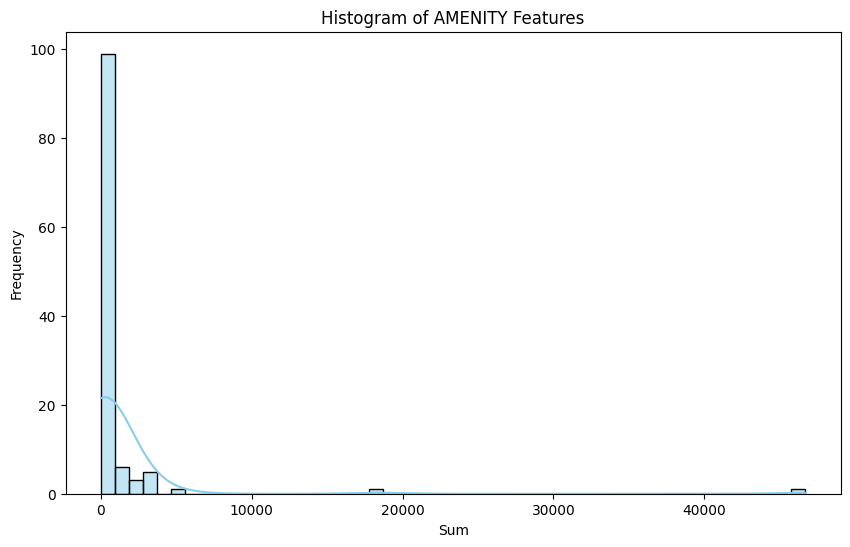

count      116.000000
mean      1017.008621
std       4685.632106
min          7.000000
25%         21.000000
50%         63.000000
75%        449.750000
max      46696.000000
dtype: float64


Most common features for AMENITY: 
 ['A_bench', 'A_bicycle_', 'A_doctors', 'A_fast_foo', 'A_kinderga', 'A_parking', 'A_parking_', 'A_parkin_1', 'A_recyclin', 'A_restaura', 'A_school', 'A_shelter', 'A_universi', 'A_vending_', 'A_waste_ba', 'A_waste_di']


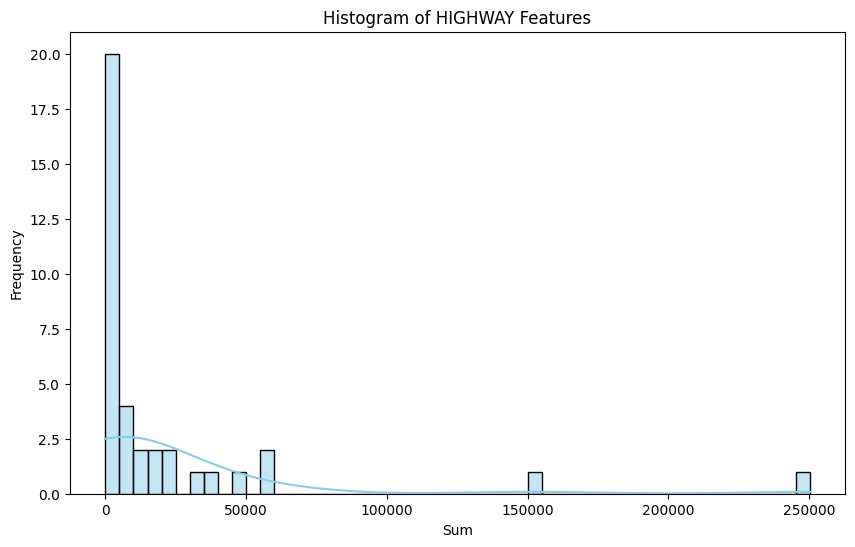

count        37.000000
mean      21610.459459
std       47655.866592
min          28.000000
25%         301.000000
50%        3853.000000
75%       19771.000000
max      250191.000000
dtype: float64


Most common features for HIGHWAY: 
 ['H_footway', 'H_resident', 'H_service', 'H_track']


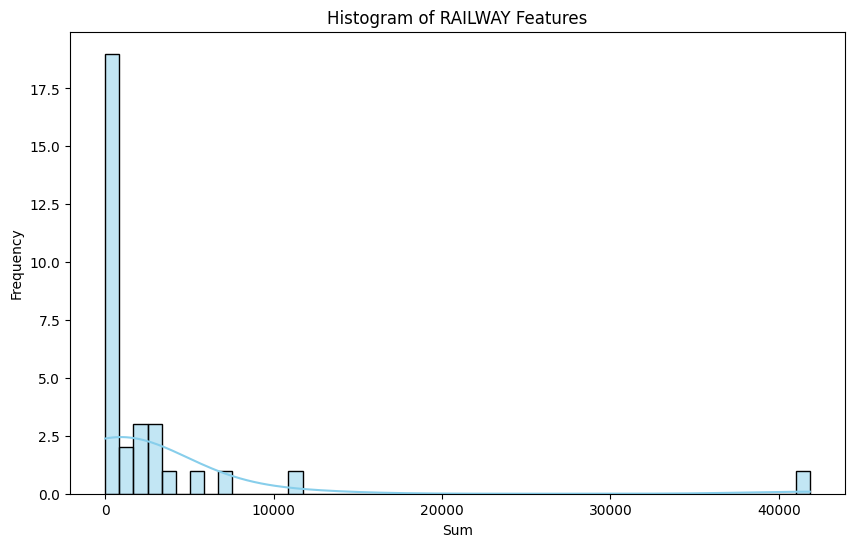

count       32.000000
mean      2782.937500
std       7549.932091
min          7.000000
25%         66.500000
50%        376.000000
75%       2295.500000
max      41838.000000
dtype: float64


Most common features for RAILWAY: 
 ['R_abandone', 'R_rail', 'R_tram']


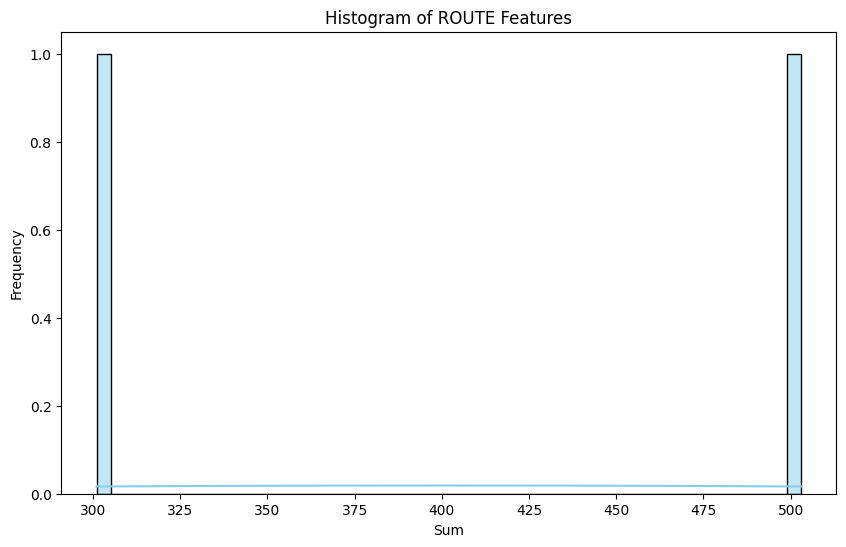

count      2.00000
mean     402.00000
std      142.83557
min      301.00000
25%      351.50000
50%      402.00000
75%      452.50000
max      503.00000
dtype: float64


Most common features for ROUTE: 
 []

All Most Common Features in the City:
A_bench
A_bicycle_
A_doctors
A_fast_foo
A_kinderga
A_parking
A_parking_
A_parkin_1
A_recyclin
A_restaura
A_school
A_shelter
A_universi
A_vending_
A_waste_ba
A_waste_di
H_footway
H_resident
H_service
H_track
R_abandone
R_rail
R_tram


In [18]:
# resolution=8
# merged_gdf = merge_gdf(resolution)

all_most_common_features = []
feature_groups = [FeatureGoups.AMENITY, FeatureGoups.HIGHWAY, FeatureGoups.RAILWAY, FeatureGoups.ROUTE]
for feature_group in feature_groups:
    all_most_common_features.extend(analyze_features(merged_gdf, feature_group))
    
print(f"\nAll Most Common Features in the City:")
for feature in all_most_common_features:
    print(feature)

### SHAP

Analysis for Resolution = 8


100%|██████████| 1094/1094 [20:43<00:00,  1.14s/it]


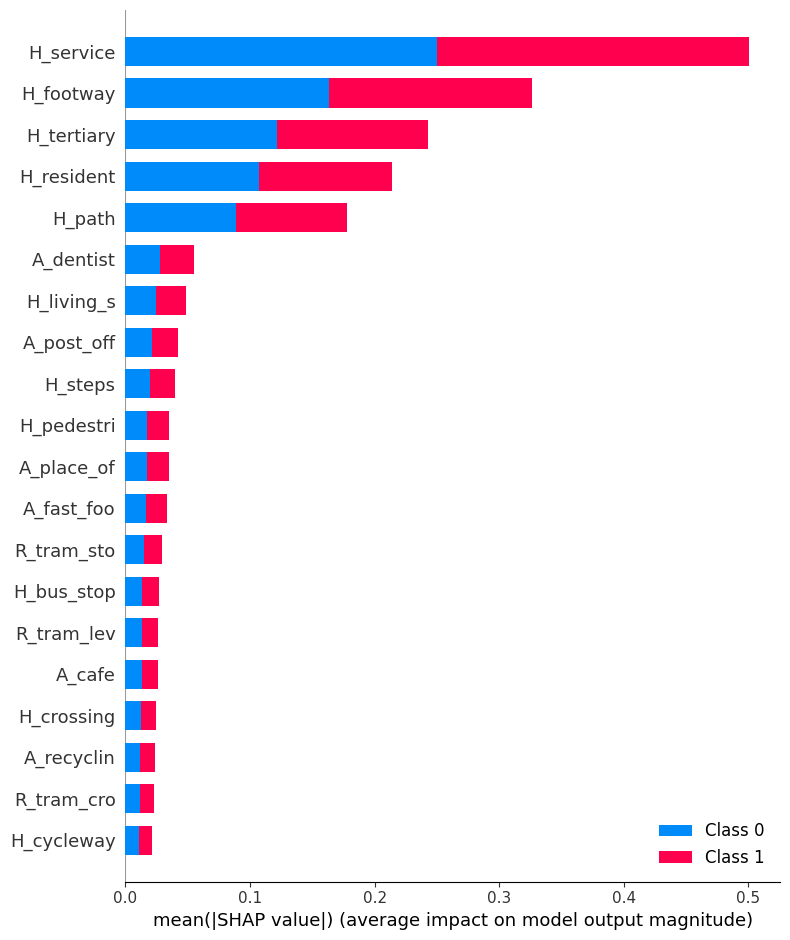

Analysis for Resolution = 9


100%|██████████| 7158/7158 [30:17<00:00,  3.94it/s]


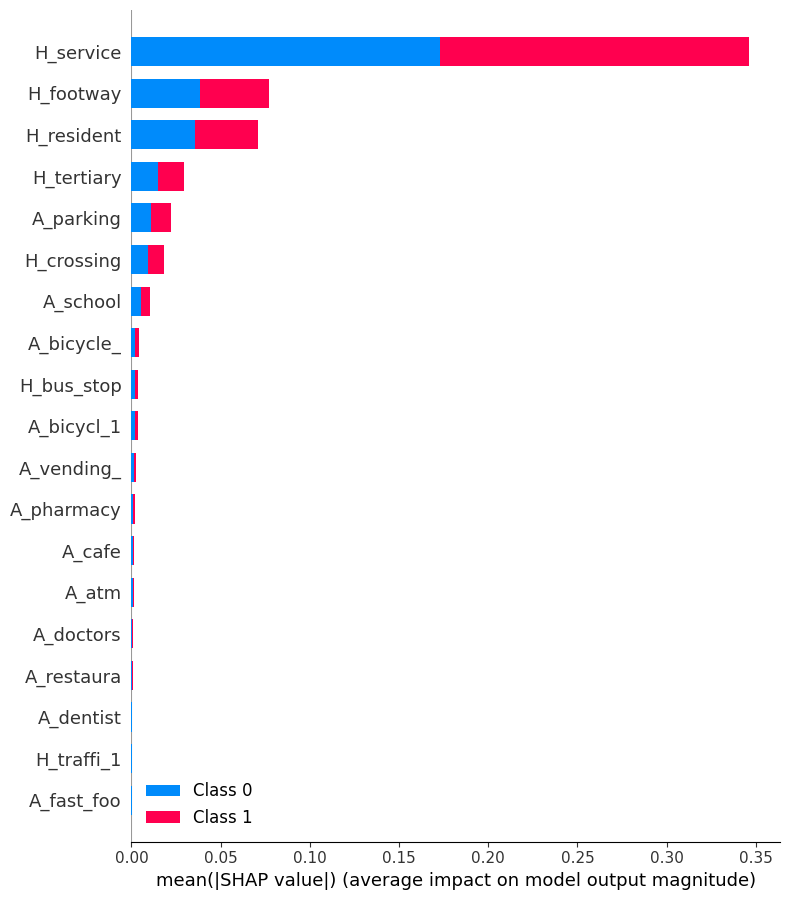

In [57]:
json_file_path = json_folder_path + f'all_high_corr_features_{city_name}.json'    
with open(json_file_path, 'r') as json_file:
    all_high_corr_features = json.load(json_file)
    
for resolution, highest_corr_features in all_high_corr_features.items():
    if highest_corr_features != []:
        merged_gdf = merge_gdf(resolution)
        shap_analysis(h3_resolution=resolution, merged_gdf=merged_gdf, selected_features=highest_corr_features)
    

### Moran's I

In [54]:
print("Local Moran's I Results:")
for resolution, results in local_moran_results.items():
    print(f"Resolution {resolution}: Moran's I = {results['moran_i']}, p_sim = {results['p_sim']}, q = {results['q']}")

Local Moran's I Results:
Resolution 8: Moran's I = [0.08490015 0.08490015 0.06165651 ... 0.18216538 0.04719925 0.04327151], p_sim = [0.015 0.001 0.027 ... 0.001 0.252 0.054], q = [3 3 3 ... 1 1 1]
Resolution 9: Moran's I = [0.03020985 0.03020985 0.03020985 ... 0.03020985 0.03020985 0.03020985], p_sim = [0.001 0.037 0.039 ... 0.257 0.057 0.001], q = [3 3 3 ... 3 3 3]
Resolution 10: Moran's I = [0.00614516 0.00614516 0.00614516 ... 0.00614516 0.00614516 0.00614516], p_sim = [0.001 0.001 0.001 ... 0.334 0.334 0.235], q = [3 3 3 ... 3 3 3]


In [55]:
res = {}
for resolution, results in local_moran_results.items():
    res[resolution] = []
    for key, value in results.items():
        res[resolution].extend([np.mean(value), np.std(value), np.min(value), np.max(value)])

local_moran_metrics = list(local_moran_results.values())[0].keys()
id_names = [f'{key}_{stat}' for key in local_moran_metrics for stat in ['mean', 'std', 'min', 'max']]
        
df = pd.DataFrame(res, index=id_names)
df.columns = [f'resolution={resolution}' for resolution in df.columns]
display(df)

,resolution=8,resolution=9,resolution=10
moran_i_mean,0.528101,0.319599,0.189822
moran_i_std,3.535825,4.492784,9.672470
moran_i_min,-0.746060,-1.466441,-1.330343
moran_i_max,63.056471,223.497906,1421.719561
p_sim_mean,0.050054,0.058014,0.010737
p_sim_std,0.102154,0.057937,0.057181
p_sim_min,0.001000,0.001000,0.001000
p_sim_max,0.500000,0.481000,0.418000
q_mean,2.695115,2.718441,2.923785
q_std,0.781277,0.573897,0.306412


#### Wnioski

**moran_i** <br>
Dla rozdzielczości 8 (największe hexy) obserwujemy silniejszy lokalny wzorzec korelacji. Oznacza to, że obszary o podobnych wartościach są bardziej skupione przestrzennie dla większych heksagonów. Odchylenie standardowe jest największe równiez dla rozdzielczości 8, co wskazuje na większą zmienność lokalnej korelacji przestrzennej w obszarach o większych heksagonach.

**p-wartość** <br>
Wartości p_sim są stosunkowo niskie dla wszystkich rozdzielczości, co wskazuje na istotność statystyczną lokalnego wzorca przestrzennej korelacji. Największe wartości p_sim (bliskie 0.5) mogą pochodzić z obszarów o losowym rozkładzie, gdzie brak jest wyraźnych lokalnych wzorców. Wartości minimalne i wartość średnia sugerują, że dla większości obszarów lokalne wzorce korelacji są istotne.

**Q** <br>
Średnie wartości Q dla wszystkich rozdzielczości wskazują na to, że istnieją klastry obszarów o podobnych wartościach w sąsiedztwie. Maksymalna wartość Q dla rozdzielczości 8 i 9 wynosi 4, co sugeruje, że istnieją obszary otoczone przez obszary o podobnych wartościach.